# MLP (Multi Layer Perceptron) Verion of Makemore


In [50]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [51]:
words = open("names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [52]:
len(words)


32033

In [53]:
chars = sorted(list(set("".join(words))))
stoi = {c: i + 1 for i, c in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [54]:
# build the dataset

block_size = 3  # context length: how many chars do we take to predict the next
X, Y = [], []
for word in words:  # words[:5] # uses only 5 words -> 32 inputs
    # print(word)
    context = [0] * block_size
    for char in word + ".":
        ix = stoi[char]
        X.append(context)
        Y.append(ix)
        # print("".join(itos[i] for i in context), f"-> {itos[ix]}")
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)


In [55]:
assert isinstance(X, torch.Tensor)
assert isinstance(Y, torch.Tensor)
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [56]:
# build the dataset


def build_dataset(words: list[str]):
    block_size = 3
    X, Y = [], []
    for word in words:
        context = [0] * block_size
        for char in word + ".":
            ix = stoi[char]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtrain, Ytrain = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


### _Note_:

X is a Matrix of inputs, it is a list (vector, tensor) of inputs (vectors, tensors) of length `block_size`

Y represents the outputs (index of the char in our itos table) for these inputs


In [57]:
C = torch.randn((27, 2))

In [58]:
C[5]

tensor([-0.4596,  1.6692])

In [59]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C  # similar, but wont use


tensor([-0.4596,  1.6692])

In [60]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [61]:
W1 = torch.randn(
    (6, 100)
)  # First layer, 100 neurons, each taking 6 inputs (2 per input/embedding from C * 3 which is the block_size)
b1 = torch.randn(100)  # 100 biases

In [62]:
# We want to have 6 inputs, so (32, 6), but emb.shape is (32, 3, 2)
# 32 = len(X) ou len(Y), 3 = block_size, 2 = vient de C qui est une liste de vecteurs de longueur 2
# torch.cat(torch.unbind(emb, 1), 1).shape
# emb.reshape(
#     (32, 6)
# )  # works too, but can reallocate, if it can return a view it does it, but we'd rather be explicit

In [63]:
# emb.view((32, 6))  # Uses the same underlying data


In [64]:
h = torch.tanh(
    emb.view((-1, 6)) @ W1 + b1
)  # hidden layer, works, think about the shapes of the ops and broadcasting

In [65]:
h.shape


torch.Size([228146, 100])

In [66]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)


In [67]:
logits = h @ W2 + b2


In [68]:
logits.shape


torch.Size([228146, 27])

In [69]:
counts = logits.exp()


In [70]:
prob = counts / counts.sum(1, keepdim=True)


In [71]:
prob.shape


torch.Size([228146, 27])

In [72]:
Y


tensor([ 5, 13, 13,  ..., 26, 24,  0])

In [73]:
# prob[torch.arange(32), Y]  # gives us the probabilities for the characters

In [74]:
# loss = -prob[torch.arange(32), Y].log().mean()
# loss


# More respectable


In [88]:
Xtrain.shape, Ytrain.shape  # dataset


(torch.Size([182625, 3]), torch.Size([182625]))

In [131]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [132]:
sum(p.nelement() for p in parameters)  # total number of parameters


11897

In [133]:
for p in parameters:
    p.requires_grad = True

In [134]:
lre = torch.linspace(0, -3, 1000)
lrs = 10**lre

In [135]:
lri = []
lossi = []
stepi = []

In [136]:
for i in range(200_000):
    # minibatch construct
    ix = torch.randint(0, Xtrain.shape[0], (128,))

    # forward pass
    emb = C[
        Xtrain[ix]
    ]  # (32, 3, 2) for 5 words, (228146, 3, 2) for the whole dataset, etc for training
    h = torch.tanh(
        emb.view((-1, 30)) @ W1 + b1
    )  # (32, 10) for 5 words, (228146, 10) for the whole dataset, etc for training
    logits = (
        h @ W2 + b2
    )  # (32, 27) for 5 words, (228146, 27) for the whole dataset, etc for training
    # v Manual loss computation v
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdim=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    # v Using the appropriate function, that does the exact same v
    #           It is more optimised too
    loss = F.cross_entropy(logits, Ytrain[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # print(loss.item())

    # update params
    # lr = lrs[i]
    lr = 0.1 if i < 100_000 else 0.01

    for p in parameters:
        assert p.grad is not None
        p.data += -lr * p.grad

    # # track stats
    # lri.append(lr)
    stepi.append(i)
    lossi.append(loss.log10().item())

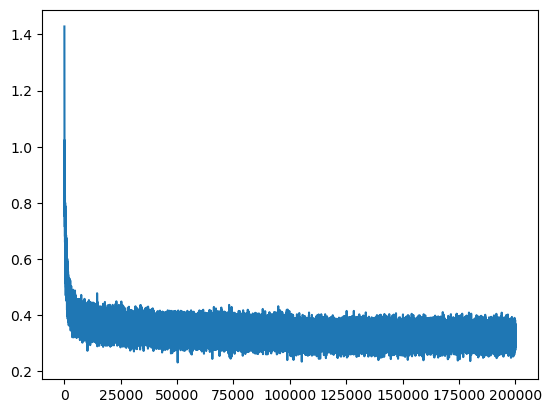

In [137]:
plt.plot(stepi, lossi)

In [138]:
# Real training loss, not just batch loss
emb = C[Xdev]
h = torch.tanh(emb.view((-1, 30)) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss.item()

2.1579036712646484

In [83]:
# training split, dev/validation split, test split
# 80,             10,                   10

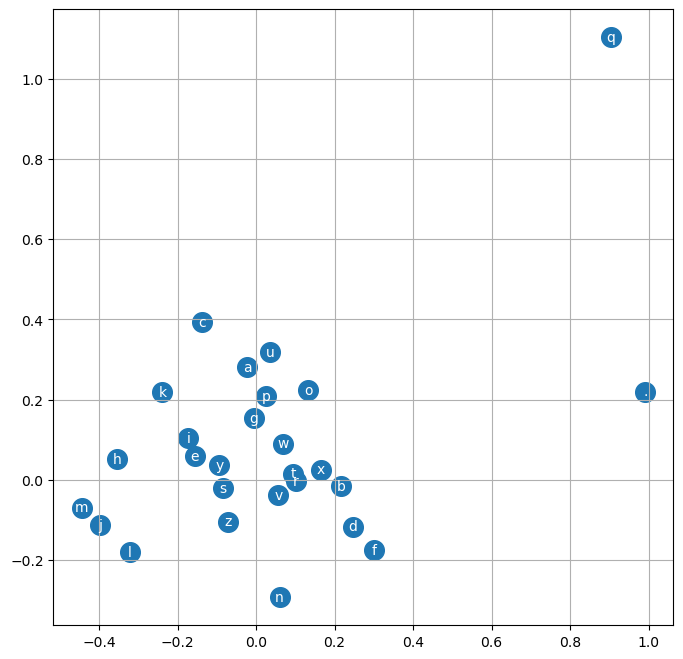

In [139]:
plt.figure(figsize=(8, 8))
plt.scatter(
    C[:, 0].data, C[:, 1].data, s=200
)  # Only works when the embedding len is 2 ;)
for i in range(C.shape[0]):
    plt.text(
        C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white"
    )
plt.grid("minor")  # type: ignore

In [142]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]  # (1, block_size, d) where d = embedding len
        h = torch.tanh(emb.view((1, -1)) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print("".join(itos[i] for i in out)[:-1])

carmahela
jhavi
kimre
rey
cassanden
jazhetlan
livia
kaeli
nellara
chaiir
kaleigh
ham
jory
quinn
shovera
jadis
watthoniearyx
kai
evidusabee
deci
